In [2]:
import os
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
import numpy as np
import model_structure
import torchvision.models as models
path = "/Users/liushiwen/Desktop/大四下/hw2/test_data"
path = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train"
dir_list = os.listdir(path)

print(f"Files and directories in '{path}':")
# for item in dir_list:
#     print(item)


Files and directories in 'D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_train':


0	0.7734375	0.4296875	0.21875	0.21875

(128, 128, 4)


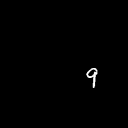

In [3]:
f = open(f"{path}/0000002.txt", "r")
print(f.read())
img = Image.open(f'{path}/0121744.png')
img = np.array(img)
print(img.shape)
img = Image.fromarray(img[:,:,2])
display(img)

In [4]:
img = Image.open(f'{path}/0121700.png')
r, g, b, trash = img.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)

# Check if all channels have the same array values
are_channels_same = np.array_equal(r_array, g_array) and np.array_equal(g_array, b_array)
are_channels_same

True

In [5]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files = [f for f in os.listdir(data_folder) if f.endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = read_image(image_path)
        image = image[0:3].float()
        # image = image.reshape(1, 128, 128)
        
        txt_file = os.path.splitext(self.image_files[idx])[0] + ".txt"
        txt_path = os.path.join(self.data_folder, txt_file)
        with open(txt_path, "r") as f:
            first_line = f.readline().strip()
            class_label = int(first_line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_label
    
# class CustomImageDataset(Dataset):
#     def __init__(self, data_folder, transform=None):
#         self.data_folder = data_folder
#         self.transform = transform
#         self.classes = self._find_classes(data_folder)
#         self.samples = self._make_dataset(data_folder)

#     def _find_classes(self, dir):
#         """
#         Finds the class folders in a dataset.
        
#         Returns:
#             A mapping from class names to class indices.
#         """
#         # Assuming class names are in the filenames before an underscore '_'
#         class_names = sorted({file.split("_")[0] for file in os.listdir(dir) if file.endswith(".png")})
#         class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
#         return class_to_idx
    
#     def _make_dataset(self, dir):
#         """
#         Creates a list of samples from the dataset directory.
#         """
#         images = [f for f in os.listdir(dir) if f.endswith(".png")]
#         samples = []
#         for img_name in images:
#             class_name = img_name.split("_")[0]
#             class_idx = self.classes[class_name]
#             samples.append((os.path.join(dir, img_name), class_idx))
#         return samples

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         image_path, label = self.samples[idx]
#         image = read_image(image_path)
#         image = image[0:1].float()  # Assuming you still want to do this

#         if self.transform:
#             image = self.transform(image)

#         return image, label
transform = transforms.Compose([transforms.Resize((128, 128)),
                                ])
data_folder = path
custom_dataset = CustomImageDataset(data_folder, transform)


In [6]:
import random
from torch.utils.data import DataLoader, Subset
def get_dataloaders(data_folder, transform, train_ratio, val_ratio, batch_size):
    # Create a single merged dataset
    train_dataset = CustomImageDataset(data_folder, transform)
    val_dataset = CustomImageDataset(data_folder, transform)
    test_dataset = CustomImageDataset(data_folder, transform)

    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"Data Transform: {transform}")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders

In [7]:
loaders = get_dataloaders(data_folder, transform, 0.6, 0.5, 256)

--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [85578, 65585, 59926, 40240, 24393]
--------- INDEX shuffled ---------

Total number of samples: 97396 datapoints
Number of train samples: 229 batches/ 58437 datapoints
Number of val samples: 77 batches/ 19479 datapoints
Number of test samples: 77 batches/ 19480 datapoints
Data Transform: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
)



In [8]:
# train_loader = loaders['train']
# val_loader = loaders['val']
# test_loader = loaders['test']

In [9]:
# print(custom_dataset[0][0])

In [10]:
# # train_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)
# # test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# print(len(train_loader))

In [11]:
def count_parameters(model):
    total_num = 0

    for parameter in model.parameters():
        if parameter.requires_grad:
            total_num += parameter.numel() 
    return total_num


In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
class mod_resnet(nn.Module):
    def __init__(self, block, layers, channel_num_list, num_classes=1000):
        super(mod_resnet, self).__init__()
        self.in_channels = channel_num_list[0]
        self.conv1 = nn.Conv2d(3, channel_num_list[0], kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_num_list[0])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, channel_num_list[1], layers[0])
        # self.layer2 = self._make_layer(block, channel_num_list[2], layers[1], stride=2)
        # self.layer3 = self._make_layer(block, channel_num_list[3], layers[2], stride=2)
        # self.layer4 = self._make_layer(block, channel_num_list[4], layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel_num_list[-1] * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [13]:
# def modify_resnet18(model):
#     # Load a pretrained ResNet-18 model
#     print(count_parameters(model))
    
#     # Remove the 3rd and 4th layer groups
#     model.layer2 = nn.Identity()
#     model.layer3 = nn.Identity()
#     model.layer4 = nn.Flatten()

#     num_features = 64 * 56 * 56
#     model.fc = nn.Linear(num_features, 10)  # Example: 1000 classes, adjust as necessary
#     print(count_parameters(model))

#     return model
# print(model)

In [14]:
from datetime import datetime

def pprint(output = '\n', show_time = False): # print and fprint at the same time
    filename = "record_BottleNeck_4.txt"
    print(output)
    with open(filename, 'a') as f:
        if show_time:
            f.write(datetime.now().strftime("[%Y-%m-%d %H:%M:%S] "))

        f.write(str(output))
        f.write('\n')
pprint("optimize small resnet", True)

optimize small resnet


In [15]:
# weight = "C:/Users/User/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth"
# model = ResNet(BasicBlock, [2, 2, 2, 2])
# model = models.resnet18()
# model = modify_resnet18(model)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.load_state_dict(torch.load(weight))
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model  = model_structure.SimpleCNN()
import time
import torchvision.models as models
from torch import nn, optim
from tqdm import tqdm
def train(model, model_name):
    pprint(f"test modify Resnet18 {model_name}", True)
    model_parameters_amount = count_parameters(model)
    pprint(f"model total parameters: {model_parameters_amount:,}")

    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    lr= 0.005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    pprint(f"learning rate={lr}")
    iteration = 0
    epochs = 20
    start = time.time()
    phases = ['train','val']
    for epoch in range(epochs):
        for phase in phases:
            running_loss = 0.0
            correct_predictions = 0
            correct_top3_predictions = 0
            total_samples = 0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            for images, labels in tqdm(loaders[phase]): # Iterate over data.
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train': # backward + optimize only if in training phase
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()

                # Convert outputs to predicted class by selecting the class with the highest score
                _, predicted = torch.max(outputs, 1)
                # Accumulate the number of correct predictions
                correct_predictions += (predicted == labels).sum().item()
                
                _, top3_preds = outputs.topk(3, 1, True, True)
                correct_top3_predictions += sum([labels[i] in top3_preds[i] for i in range(labels.size(0))])

                total_samples += labels.size(0)
                iteration += 1
                # if iteration % 20 == 0:
                #     print(iteration)
            avg_loss = running_loss / total_samples
            top1_accuracy = correct_predictions / total_samples * 100
            top3_accuracy = correct_top3_predictions / total_samples * 100
            pprint(f"Epoch [{epoch+1}/{epochs}], phase: {phase}, samples: {total_samples}, Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%")
    end = time.time()
    duration = end - start
    pprint(f"Elapsed time: {duration} seconds")
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_scripted.save(f'{model_name}.pt') # Save
    pprint(f"weight saved as: {model_name}.pt")

In [20]:
model_list = [
    # mod_resnet(Bottleneck, [1, 0,0,0], channel_num=64, num_classes=10),
    # mod_resnet(Bottleneck, [1, 0,0,0], channel_num=16, num_classes=10),
    # mod_resnet(BasicBlock, [2, 0,0,0], channel_num=32, num_classes=10),
    # mod_resnet(BasicBlock, [2, 0,0,0], channel_num=16, num_classes=10),
    # mod_resnet(BasicBlock, [2, 0,0,0], channel_num=4, num_classes=10),
    # mod_resnet(Bottleneck, [2, 0,0,0], channel_num=16, num_classes=10),
    # mod_resnet(Bottleneck, [2, 0,0,0], channel_num=4, num_classes=10),
    # mod_resnet(Bottleneck, [4, 0,0,0], channel_num=2, num_classes=10),
    # mod_resnet(Bottleneck, [4, 0,0,0], channel_num=4, num_classes=10),
    # mod_resnet(Bottleneck, [2, 0,0,0], channel_num=8, num_classes=10),
    # mod_resnet(Bottleneck, [2, 2,0,0], channel_num_list=[8, 4], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1,1,1], channel_num_list=[4,4,8, 8], num_classes=10),
    # mod_resnet(Bottleneck, [2, 0, 0, 0], channel_num_list=[8,4], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[8,8,4], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[8,4,8], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[4,8,4], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[4,4,8], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[4,8,8], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[8,4,4], num_classes=10),
    # mod_resnet(Bottleneck, [1, 1, 0, 0], channel_num_list=[8,4,8], num_classes=10),
    mod_resnet(Bottleneck, [2, 0, 0, 0], channel_num_list=[2,2], num_classes=10),
    mod_resnet(Bottleneck, [2, 0, 0, 0], channel_num_list=[1,1], num_classes=10),

]

model_name = [
    # "resnet4_btnk",
    # "resnet4_btnk_ch16",
    # "resnet6_ch32",
    # "resnet6_ch16",
    # "resnet6_ch4",
    # "resnet6_btnk_ch16",
    # "resnet6_btnk_ch4",
    # "resnet10_btnk_ch2",
    # "resnet10_btnk_ch4",
    # "resnet6_btnk_ch8",
    # "resnet10_btnk_ch4n8",
    # "resnet10_btnk_ch4n4n8n8",
    # "R6_btnk_8ch4"
    # "R6_btnk_ch8n4",
    # "R6_btnk_8ch4n8",
    # "R6_btnk_4ch8n4",
    # "R6_btnk_ch4n8",
    # "R6_btnk_4ch8",
    # "R6_btnk_8ch4",
    # "R6_btnk_ch8(2)",
    "R6_btnk_ch2",
    "R6_btnk_ch1",
]
for ii in range(len(model_name)):
    train(model_list[ii], model_name[ii])

test modify Resnet18 R6_btnk_ch2
model total parameters: 592
learning rate=0.005


  0%|          | 1/229 [00:00<00:47,  4.76it/s]

100%|██████████| 229/229 [00:42<00:00,  5.41it/s]


Epoch [1/20], phase: train, samples: 58437, Loss: 0.0080, Top-1 Accuracy: 21.64%, Top-3 Accuracy: 52.68%


100%|██████████| 77/77 [00:12<00:00,  6.12it/s]


Epoch [1/20], phase: val, samples: 19479, Loss: 0.0073, Top-1 Accuracy: 27.77%, Top-3 Accuracy: 64.05%


100%|██████████| 229/229 [00:41<00:00,  5.57it/s]


Epoch [2/20], phase: train, samples: 58437, Loss: 0.0068, Top-1 Accuracy: 33.25%, Top-3 Accuracy: 68.78%


100%|██████████| 77/77 [00:13<00:00,  5.89it/s]


Epoch [2/20], phase: val, samples: 19479, Loss: 0.0070, Top-1 Accuracy: 35.25%, Top-3 Accuracy: 67.96%


100%|██████████| 229/229 [00:40<00:00,  5.66it/s]


Epoch [3/20], phase: train, samples: 58437, Loss: 0.0061, Top-1 Accuracy: 43.05%, Top-3 Accuracy: 77.02%


100%|██████████| 77/77 [00:12<00:00,  6.30it/s]


Epoch [3/20], phase: val, samples: 19479, Loss: 0.0059, Top-1 Accuracy: 47.08%, Top-3 Accuracy: 80.26%


100%|██████████| 229/229 [00:40<00:00,  5.69it/s]


Epoch [4/20], phase: train, samples: 58437, Loss: 0.0054, Top-1 Accuracy: 48.50%, Top-3 Accuracy: 82.06%


100%|██████████| 77/77 [00:13<00:00,  5.87it/s]


Epoch [4/20], phase: val, samples: 19479, Loss: 0.0053, Top-1 Accuracy: 50.55%, Top-3 Accuracy: 83.32%


100%|██████████| 229/229 [00:40<00:00,  5.72it/s]


Epoch [5/20], phase: train, samples: 58437, Loss: 0.0050, Top-1 Accuracy: 52.84%, Top-3 Accuracy: 85.40%


100%|██████████| 77/77 [00:13<00:00,  5.76it/s]


Epoch [5/20], phase: val, samples: 19479, Loss: 0.0058, Top-1 Accuracy: 46.63%, Top-3 Accuracy: 80.55%


100%|██████████| 229/229 [00:41<00:00,  5.58it/s]


Epoch [6/20], phase: train, samples: 58437, Loss: 0.0047, Top-1 Accuracy: 55.92%, Top-3 Accuracy: 87.35%


100%|██████████| 77/77 [00:12<00:00,  6.29it/s]


Epoch [6/20], phase: val, samples: 19479, Loss: 0.0048, Top-1 Accuracy: 53.20%, Top-3 Accuracy: 85.79%


100%|██████████| 229/229 [00:40<00:00,  5.68it/s]


Epoch [7/20], phase: train, samples: 58437, Loss: 0.0045, Top-1 Accuracy: 58.15%, Top-3 Accuracy: 88.49%


100%|██████████| 77/77 [00:12<00:00,  6.16it/s]


Epoch [7/20], phase: val, samples: 19479, Loss: 0.0052, Top-1 Accuracy: 50.59%, Top-3 Accuracy: 83.82%


100%|██████████| 229/229 [00:38<00:00,  5.93it/s]


Epoch [8/20], phase: train, samples: 58437, Loss: 0.0043, Top-1 Accuracy: 59.76%, Top-3 Accuracy: 89.49%


100%|██████████| 77/77 [00:12<00:00,  6.02it/s]


Epoch [8/20], phase: val, samples: 19479, Loss: 0.0044, Top-1 Accuracy: 58.05%, Top-3 Accuracy: 89.60%


100%|██████████| 229/229 [00:39<00:00,  5.80it/s]


Epoch [9/20], phase: train, samples: 58437, Loss: 0.0042, Top-1 Accuracy: 61.14%, Top-3 Accuracy: 90.40%


100%|██████████| 77/77 [00:12<00:00,  6.12it/s]


Epoch [9/20], phase: val, samples: 19479, Loss: 0.0046, Top-1 Accuracy: 57.76%, Top-3 Accuracy: 88.33%


100%|██████████| 229/229 [00:38<00:00,  5.91it/s]


Epoch [10/20], phase: train, samples: 58437, Loss: 0.0041, Top-1 Accuracy: 62.30%, Top-3 Accuracy: 90.87%


100%|██████████| 77/77 [00:11<00:00,  6.65it/s]


Epoch [10/20], phase: val, samples: 19479, Loss: 0.0041, Top-1 Accuracy: 63.36%, Top-3 Accuracy: 91.18%


100%|██████████| 229/229 [00:41<00:00,  5.57it/s]


Epoch [11/20], phase: train, samples: 58437, Loss: 0.0040, Top-1 Accuracy: 63.42%, Top-3 Accuracy: 91.31%


100%|██████████| 77/77 [00:12<00:00,  6.01it/s]


Epoch [11/20], phase: val, samples: 19479, Loss: 0.0041, Top-1 Accuracy: 64.01%, Top-3 Accuracy: 90.93%


100%|██████████| 229/229 [00:40<00:00,  5.64it/s]


Epoch [12/20], phase: train, samples: 58437, Loss: 0.0039, Top-1 Accuracy: 64.46%, Top-3 Accuracy: 91.76%


100%|██████████| 77/77 [00:13<00:00,  5.74it/s]


Epoch [12/20], phase: val, samples: 19479, Loss: 0.0041, Top-1 Accuracy: 63.95%, Top-3 Accuracy: 90.84%


100%|██████████| 229/229 [00:41<00:00,  5.48it/s]


Epoch [13/20], phase: train, samples: 58437, Loss: 0.0038, Top-1 Accuracy: 65.56%, Top-3 Accuracy: 92.05%


100%|██████████| 77/77 [00:12<00:00,  6.37it/s]


Epoch [13/20], phase: val, samples: 19479, Loss: 0.0043, Top-1 Accuracy: 60.91%, Top-3 Accuracy: 89.78%


100%|██████████| 229/229 [00:38<00:00,  5.99it/s]


Epoch [14/20], phase: train, samples: 58437, Loss: 0.0038, Top-1 Accuracy: 66.63%, Top-3 Accuracy: 92.46%


100%|██████████| 77/77 [00:13<00:00,  5.62it/s]


Epoch [14/20], phase: val, samples: 19479, Loss: 0.0038, Top-1 Accuracy: 67.53%, Top-3 Accuracy: 92.25%


100%|██████████| 229/229 [00:38<00:00,  5.94it/s]


Epoch [15/20], phase: train, samples: 58437, Loss: 0.0037, Top-1 Accuracy: 67.77%, Top-3 Accuracy: 92.84%


100%|██████████| 77/77 [00:10<00:00,  7.26it/s]


Epoch [15/20], phase: val, samples: 19479, Loss: 0.0037, Top-1 Accuracy: 68.59%, Top-3 Accuracy: 92.56%


100%|██████████| 229/229 [00:39<00:00,  5.76it/s]


Epoch [16/20], phase: train, samples: 58437, Loss: 0.0036, Top-1 Accuracy: 68.56%, Top-3 Accuracy: 93.17%


100%|██████████| 77/77 [00:12<00:00,  6.01it/s]


Epoch [16/20], phase: val, samples: 19479, Loss: 0.0037, Top-1 Accuracy: 68.58%, Top-3 Accuracy: 92.61%


100%|██████████| 229/229 [00:39<00:00,  5.77it/s]


Epoch [17/20], phase: train, samples: 58437, Loss: 0.0035, Top-1 Accuracy: 69.20%, Top-3 Accuracy: 93.35%


100%|██████████| 77/77 [00:12<00:00,  6.10it/s]


Epoch [17/20], phase: val, samples: 19479, Loss: 0.0037, Top-1 Accuracy: 68.18%, Top-3 Accuracy: 92.30%


100%|██████████| 229/229 [00:40<00:00,  5.60it/s]


Epoch [18/20], phase: train, samples: 58437, Loss: 0.0035, Top-1 Accuracy: 69.80%, Top-3 Accuracy: 93.55%


100%|██████████| 77/77 [00:12<00:00,  6.41it/s]


Epoch [18/20], phase: val, samples: 19479, Loss: 0.0037, Top-1 Accuracy: 68.40%, Top-3 Accuracy: 92.55%


100%|██████████| 229/229 [00:42<00:00,  5.33it/s]


Epoch [19/20], phase: train, samples: 58437, Loss: 0.0034, Top-1 Accuracy: 70.64%, Top-3 Accuracy: 93.65%


100%|██████████| 77/77 [00:12<00:00,  6.22it/s]


Epoch [19/20], phase: val, samples: 19479, Loss: 0.0036, Top-1 Accuracy: 69.60%, Top-3 Accuracy: 92.66%


100%|██████████| 229/229 [00:42<00:00,  5.36it/s]


Epoch [20/20], phase: train, samples: 58437, Loss: 0.0034, Top-1 Accuracy: 71.63%, Top-3 Accuracy: 93.84%


100%|██████████| 77/77 [00:11<00:00,  6.80it/s]


Epoch [20/20], phase: val, samples: 19479, Loss: 0.0035, Top-1 Accuracy: 69.94%, Top-3 Accuracy: 92.98%
Elapsed time: 1058.6547610759735 seconds
weight saved as: R6_btnk_ch2.pt
test modify Resnet18 R6_btnk_ch1
model total parameters: 266
learning rate=0.005


100%|██████████| 229/229 [00:40<00:00,  5.60it/s]


Epoch [1/20], phase: train, samples: 58437, Loss: 0.0086, Top-1 Accuracy: 19.24%, Top-3 Accuracy: 48.07%


100%|██████████| 77/77 [00:11<00:00,  6.53it/s]


Epoch [1/20], phase: val, samples: 19479, Loss: 0.0081, Top-1 Accuracy: 22.49%, Top-3 Accuracy: 57.86%


100%|██████████| 229/229 [00:39<00:00,  5.84it/s]


Epoch [2/20], phase: train, samples: 58437, Loss: 0.0078, Top-1 Accuracy: 23.44%, Top-3 Accuracy: 60.50%


100%|██████████| 77/77 [00:11<00:00,  6.50it/s]


Epoch [2/20], phase: val, samples: 19479, Loss: 0.0076, Top-1 Accuracy: 26.53%, Top-3 Accuracy: 64.05%


100%|██████████| 229/229 [00:40<00:00,  5.61it/s]


Epoch [3/20], phase: train, samples: 58437, Loss: 0.0072, Top-1 Accuracy: 26.93%, Top-3 Accuracy: 67.12%


100%|██████████| 77/77 [00:11<00:00,  6.75it/s]


Epoch [3/20], phase: val, samples: 19479, Loss: 0.0077, Top-1 Accuracy: 21.12%, Top-3 Accuracy: 56.47%


100%|██████████| 229/229 [00:38<00:00,  6.01it/s]


Epoch [4/20], phase: train, samples: 58437, Loss: 0.0068, Top-1 Accuracy: 29.96%, Top-3 Accuracy: 71.65%


100%|██████████| 77/77 [00:11<00:00,  6.54it/s]


Epoch [4/20], phase: val, samples: 19479, Loss: 0.0069, Top-1 Accuracy: 29.08%, Top-3 Accuracy: 70.14%


100%|██████████| 229/229 [00:39<00:00,  5.83it/s]


Epoch [5/20], phase: train, samples: 58437, Loss: 0.0067, Top-1 Accuracy: 31.53%, Top-3 Accuracy: 73.54%


100%|██████████| 77/77 [00:11<00:00,  6.57it/s]


Epoch [5/20], phase: val, samples: 19479, Loss: 0.0067, Top-1 Accuracy: 31.59%, Top-3 Accuracy: 73.26%


100%|██████████| 229/229 [00:53<00:00,  4.29it/s]


Epoch [6/20], phase: train, samples: 58437, Loss: 0.0066, Top-1 Accuracy: 32.26%, Top-3 Accuracy: 74.35%


100%|██████████| 77/77 [00:11<00:00,  6.71it/s]


Epoch [6/20], phase: val, samples: 19479, Loss: 0.0076, Top-1 Accuracy: 19.64%, Top-3 Accuracy: 58.54%


100%|██████████| 229/229 [00:43<00:00,  5.27it/s]


Epoch [7/20], phase: train, samples: 58437, Loss: 0.0065, Top-1 Accuracy: 32.71%, Top-3 Accuracy: 75.12%


 81%|████████  | 62/77 [00:09<00:02,  6.38it/s]

In [21]:
import torch
model = torch.jit.load('R6_btnk_8ch4.pt')
print(count_parameters(model))
# model.eval()

2418


In [ ]:
data_folder = "D:\Casper\OTHER\Data\MNIST2\HW2_MNIST_test"

test_dataset = CustomImageDataset(data_folder, transform)

test_loader = DataLoader(custom_dataset, batch_size=128)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(test_loader))


761


In [21]:
# import torch
# import csv

# # Assuming model is your trained model and test_loader is your DataLoader for the test dataset
# model.eval()  # Set the model to evaluation mode

# # Path to save the CSV file
# output_csv_path = 'test_predictions.csv'

# with torch.no_grad():  # No need to track gradients for validation
#     with open(output_csv_path, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['filename', 'class'])  # Write the header row

#         for images, labels, filenames in test_loader:  # Assuming filenames are provided
#             images = images.cuda()
#             outputs = model(images)

#             _, predicted = torch.max(outputs, 1)
#             predicted_classes = [test_loader.dataset.classes[pred] for pred in predicted]  # Convert to class names if applicable

#             for filename, pred_class in zip(filenames, predicted_classes):
#                 writer.writerow([filename, pred_class])

# print(f"Results saved to {output_csv_path}")


AttributeError: 'CustomImageDataset' object has no attribute 'classes'

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 64 * 64)  # Flatten the feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset (you can replace this with your own dataset)
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root="D:\Casper\OTHER\Data\cifar", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Initialize the model
model = SimpleCNN()
model = model.cuda()
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (you can adjust the number of epochs)
for epoch in range(10):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
        
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Convert outputs to predicted class by selecting the class with the highest score
        _, predicted = torch.max(outputs, 1)
        # Accumulate the number of correct predictions
        correct_predictions += (predicted == labels).sum().item()
        # Accumulate the total number of samples seen
        total_samples += labels.size(0)

        # Optional: break here if you want to test with just the first batch
        # break

    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
        # break
    print(f"Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Files already downloaded and verified
Epoch [1/10], Loss: 1.7137, Accuracy: 37.24%
Epoch [2/10], Loss: 1.5531, Accuracy: 43.10%
Epoch [3/10], Loss: 1.5096, Accuracy: 44.43%
Epoch [4/10], Loss: 1.4768, Accuracy: 45.74%


KeyboardInterrupt: 

In [ ]:

# Save the trained model
torch.save(model.state_dict(), "simple_cnn_model.pth")


In [3]:
import torch.nn as nn
import torch

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(10, 5)
    
    def forward(self, x):
        return self.layer1(x)

# Instantiate the model
model = SimpleModel()
x = torch.randn(1, 10)
print(model(x))
# Define a new forward function
def new_forward(self, x):
    x = self.layer1(x)
    return x +1 # Just an example modification

# Assign the new forward function to the model
model.forward = new_forward.__get__(model, SimpleModel)

# Test the modified model
print(model(x))


tensor([[-1.5898, -0.3613,  2.0499, -0.5059, -0.5985]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.5898,  0.6387,  3.0499,  0.4941,  0.4015]], grad_fn=<AddBackward0>)


In [18]:
import torchvision.models as models
def modify_resnet18():
    # Load a pretrained ResNet-18 model
    model = models.resnet18(pretrained=True)
    print(count_parameters(model))
    
    # Remove the 3rd and 4th layer groups
    model.layer2 = nn.Identity()
    model.layer3 = nn.Identity()
    model.layer4 = nn.Identity()

    # Assuming the output of layer2 is 128 channels, and considering the 
    # downsampling, calculate the size of the output feature map.
    # For a 224x224 input image, after the initial conv and maxpool, the size is 56x56.
    # After layer1, it remains 56x56 (since stride=1 in ResNet-18's layer1).
    # After layer2, due to downsampling, the size is 28x28.
    # Thus, the output size after layer2 for a 224x224 input is 128x28x28.
    # However, if your input size is different (e.g., MNIST images), you'll need to adjust this calculation.
    num_features = 64 * 28 * 28  # Adjust this based on your actual input size
    # Modify the fc layer to match this size
    model.fc = nn.Linear(num_features, 10)  # Example: 1000 classes, adjust as necessary
    print(count_parameters(model))

    return model
# Modify the ResNet-18
modified_model = modify_resnet18()

# Print the modified model summary to verify changes
print(modified_model)

11689512
659274
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [8]:
model = torch.jit.load('D:\\Casper\\aML\\HW2\\aML\\resnet4.pt')
# print(model)
print(count_parameters(model))

84170
